In [1]:
# RAF-DB Dataset GAN for Happy Smiling Faces
# Full implementation in Google Colab layout

# Prerequisites
# Make sure to install these packages in your Colab notebook
!pip install tensorflow matplotlib pandas kagglehub

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, LeakyReLU, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import os
from PIL import Image
import zipfile

In [3]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from google.colab import files
import kagglehub

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")

print("Path to dataset files:", path)

100%|██████████| 37.7M/37.7M [00:00<00:00, 127MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2


In [5]:
# Step 2: Locate and Load Labels
import os

# Inspect dataset directory
dataset_dir = '/root/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2'
print("Dataset contents:", os.listdir(dataset_dir))

Dataset contents: ['DATASET', 'train_labels.csv', 'test_labels.csv']


In [6]:
labels_path = os.path.join(dataset_dir, 'test_labels.csv')  # Adjust this based on the actual file found
if os.path.exists(labels_path):
    labels_df = pd.read_csv(labels_path)
    print("Sample labels:")
    print(labels_df.head())
else:
    print("Label file not found. Please check the dataset structure.")

Sample labels:
                   image  label
0  test_0001_aligned.jpg      5
1  test_0002_aligned.jpg      1
2  test_0003_aligned.jpg      4
3  test_0004_aligned.jpg      1
4  test_0005_aligned.jpg      5


In [7]:
labels_path = os.path.join(dataset_dir, 'train_labels.csv')  # Adjust this based on the actual file found
if os.path.exists(labels_path):
    labels_df = pd.read_csv(labels_path)
    print("Sample labels:")
    print(labels_df.head())
else:
    print("Label file not found. Please check the dataset structure.")

Sample labels:
                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


In [8]:
# Step 2: Load and inspect the labels
labels_path = '/root/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2/test_labels.csv'
labels_df = pd.read_csv(labels_path)
print("Sample labels:")
print(labels_df.head())

Sample labels:
                   image  label
0  test_0001_aligned.jpg      5
1  test_0002_aligned.jpg      1
2  test_0003_aligned.jpg      4
3  test_0004_aligned.jpg      1
4  test_0005_aligned.jpg      5


In [9]:
# Step 3: Prepare the dataset
data_dir = '/root/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2/DATASET'
img_size = 64  # Resize all images to 64x64 for GAN input

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img_array = np.asarray(img) / 127.5 - 1.0  # Normalize to [-1, 1]
    return img_array

In [10]:
# Recursively load image paths from subfolders
image_paths = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(root, file))


In [11]:
# Load and preprocess images
images = np.array([preprocess_image(img) for img in image_paths])
print(f"Loaded {len(images)} images.")

Loaded 15339 images.


In [12]:
# Step 4: Build Generator (remains unchanged)

def build_generator():
    model = Sequential([
        Dense(8 * 8 * 256, input_dim=100),
        LeakyReLU(0.2),
        Reshape((8, 8, 256)),
        BatchNormalization(),

        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),

        Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,685,571 (10.24 MB)

 Trainable params: 2,684,675 (10.24 MB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
from graphviz import Digraph

def visualize_nn():
    dot = Digraph(format='png')
    dot.attr(dpi='300')  # High resolution
    dot.attr(rankdir='TB', size='10')  # Top to Bottom layout

    # Define layers with names
    layers = [
        ('Dense', '(None, 16384)'),
        ('LeakyReLU', '(None, 16384)'),
        ('Reshape', '(None, 8, 8, 256)'),
        ('BatchNorm', '(None, 8, 8, 256)'),
        ('Conv2D_T1', '(None, 16, 16, 128)'),
        ('LeakyReLU', '(None, 16, 16, 128)'),
        ('BatchNorm', '(None, 16, 16, 128)'),
        ('Conv2D_T2', '(None, 32, 32, 64)'),
        ('LeakyReLU', '(None, 32, 32, 64)'),
        ('BatchNorm', '(None, 32, 32, 64)'),
        ('Conv2D_T3', '(None, 64, 64, 3)')
    ]

    # Add nodes to graph
    for i, (layer, shape) in enumerate(layers):
        dot.node(layer, f'{layer}\n{shape}', shape='box', style='filled', fillcolor='lightblue')

        # Connect layers sequentially
        if i > 0:
            dot.edge(layers[i-1][0], layer)

    # Save and render
    dot.render('nn_flowchart', view=True)

# Call function to generate the flowchart
visualize_nn()


In [14]:
# Step 5: Build Discriminator (remains unchanged)

def build_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from graphviz import Digraph

def visualize_nn():
    dot = Digraph(format='png')
    dot.attr(dpi='300')  # High resolution
    dot.attr(rankdir='TB', size='10')  # Top to Bottom layout

    # Define layers with names
    layers = [
        ('Conv2D_1', '(None, 32, 32, 64)'),
        ('LeakyReLU_1', '(None, 32, 32, 64)'),
        ('Dropout_1', '(None, 32, 32, 64)'),
        ('Conv2D_2', '(None, 16, 16, 128)'),
        ('LeakyReLU_2', '(None, 16, 16, 128)'),
        ('Dropout_2', '(None, 16, 16, 128)'),
        ('Flatten', '(None, 32768)'),
        ('Dense', '(None, 1)')
    ]

    # Add nodes to graph
    for i, (layer, shape) in enumerate(layers):
        dot.node(layer, f'{layer}\n{shape}', shape='box', style='filled', fillcolor='lightblue')

        # Connect layers sequentially
        if i > 0:
            dot.edge(layers[i-1][0], layer)

    # Save and render
    dot.render('nn_flowchart', view=True)

# Call function to generate the flowchart
visualize_nn()


In [16]:
# Step 6: Compile the GAN (remains unchanged)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [18]:
# Step 7: Training Loop (remains unchanged)
EPOCHS = 300
BATCH_SIZE = 16

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")


In [ ]:
# Prepare dataset for training
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(10000).batch(BATCH_SIZE)
train(dataset, EPOCHS)


Epoch 1, Generator Loss: 1.0418, Discriminator Loss: 1.7836
Epoch 2, Generator Loss: 1.2328, Discriminator Loss: 0.5882
Epoch 3, Generator Loss: 0.8643, Discriminator Loss: 1.3693
Epoch 4, Generator Loss: 0.6466, Discriminator Loss: 1.9797
Epoch 5, Generator Loss: 0.7424, Discriminator Loss: 1.6457
Epoch 6, Generator Loss: 1.0505, Discriminator Loss: 1.1665
Epoch 7, Generator Loss: 1.1086, Discriminator Loss: 1.3454
Epoch 8, Generator Loss: 1.1027, Discriminator Loss: 0.9349
Epoch 9, Generator Loss: 1.1876, Discriminator Loss: 1.3915
Epoch 10, Generator Loss: 0.8236, Discriminator Loss: 1.1440
Epoch 11, Generator Loss: 0.8002, Discriminator Loss: 1.6011
Epoch 12, Generator Loss: 0.9396, Discriminator Loss: 1.3510
Epoch 13, Generator Loss: 0.8891, Discriminator Loss: 1.1086
Epoch 14, Generator Loss: 0.8504, Discriminator Loss: 1.2663


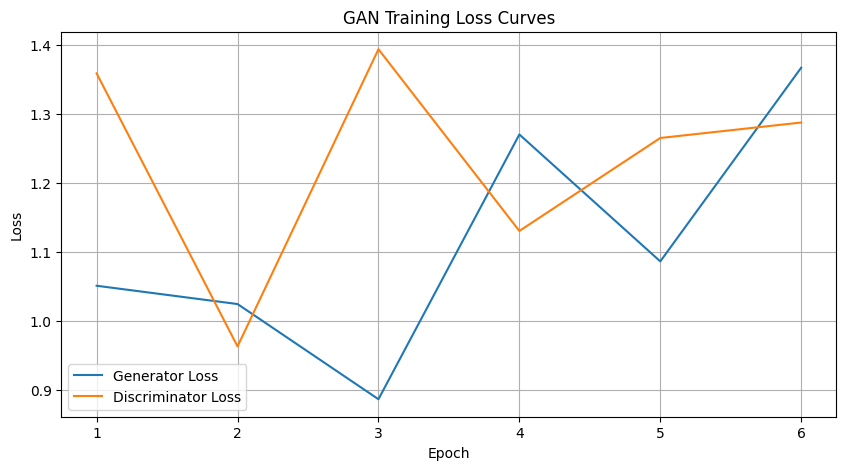

In [ ]:

import matplotlib.pyplot as plt

# Example: Replace these with your actual loss values
generator_losses = [1.0516, 1.0251, 0.8872, 1.2708, 1.0869, 1.3675]  # Example: [1.0, 0.8, 0.6, ...]
discriminator_losses = [1.3593, 0.9637, 1.3943, 1.1310, 1.2657, 1.2881] # Example: [0.5, 0.7, 0.4, ...]

# Plot the losses
epochs = range(1, len(generator_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, generator_losses, label='Generator Loss')
plt.plot(epochs, discriminator_losses, label='Discriminator Loss')
plt.title('GAN Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

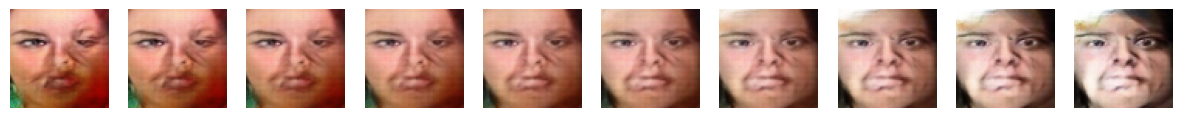

In [ ]:
# prompt: From the trained model I want to visulise the Latent Space Interpolation

# Latent Space Interpolation

# Generate two random latent vectors
latent_vector_1 = tf.random.normal([1, 100])
latent_vector_2 = tf.random.normal([1, 100])

# Number of interpolation steps
interpolation_steps = 10

# Linear interpolation between the two latent vectors
latent_vectors = []
for i in range(interpolation_steps):
    alpha = i / (interpolation_steps - 1)
    interpolated_vector = alpha * latent_vector_2 + (1 - alpha) * latent_vector_1
    latent_vectors.append(interpolated_vector)

# Generate images from the interpolated latent vectors
generated_images = generator(tf.concat(latent_vectors, axis=0))

# Rescale the images to the range [0, 1]
generated_images = (generated_images + 1) / 2.0

# Plot the generated images
plt.figure(figsize=(15, 5))
for i in range(interpolation_steps):
    plt.subplot(1, interpolation_steps, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()

In [ ]:
# prompt: by analyzing the previous code segment, I want to save and download the mmodel which I am training

# Save the generator model
generator.save('generator_model2.h5')

# Download the saved model
files.download('generator_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files


Please upload an image (any format like .jpg, .png, etc.)


Saving Input Img 3.jpg to Input Img 3.jpg


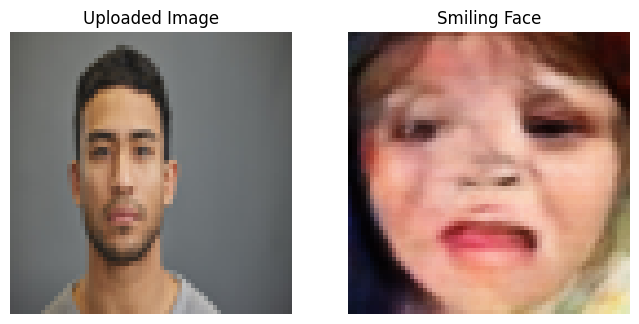

In [ ]:
# Step 8: User Input and Smiling Face Generation (remains unchanged)

def preprocess_uploaded_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img_array = np.asarray(img) / 127.5 - 1.0  # Normalize to [-1, 1]
    return img_array

def generate_smiling_face(generator):
    print("Please upload an image (any format like .jpg, .png, etc.)")
    uploaded = files.upload()
    for image_name in uploaded.keys():
        input_img = preprocess_uploaded_image(image_name)
        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)
        generated_image = (generated_image[0] + 1) / 2.0

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title("Uploaded Image")
        plt.imshow(np.asarray(Image.open(image_name).resize((64, 64))))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Smiling Face")
        plt.imshow(generated_image.numpy())
        plt.axis('off')
        plt.show()

generate_smiling_face(generator)